In [1]:
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
from keras.datasets import mnist

In [2]:
def Crop(crop_x,crop_y,M_arr,K=[]):  
    M_inv = np.zeros((28,28,len(K)))
    for i in range(len(K)):
        M_inv[:,:,i] = M_arr[i].reshape(28,28)
        
    return M_inv[crop_x:28-crop_x,crop_y:28-crop_y,:]

def Plot(crop_x,crop_y,M_arr,K=[]):
    M_inv = np.zeros((28-2*crop_x,28-2*crop_y,len(K)))
    for i in range(0,len(K)):
        M_inv[:,:,i] = M_arr[i].reshape(28-2*crop_x,28-2*crop_y)
        plt.imshow(M_inv[:,:,i], cmap=plt.get_cmap('gray'))
        plt.show()

In [3]:
def Input_mnist(crop_x,crop_y,K=[]):
    # loading
    (X, y), (k,h) = mnist.load_data()
    # Define patterns
    M_arr = np.zeros((len(K),28*28))
    l    = 0
    flag = 0
    for i in K:
        for j in range(np.size(y)):
            if y[j] == i:
                if flag == 0:
                    m = j
                    M_arr[l,:] = np.ravel(X[j,:,:]) 
                    flag = 1
                    l += 1
        flag = 0
    for i in range(len(K)):
        M_arr[i] /= np.max(M_arr[i])
    mask = M_arr<=0.5
    M_arr[mask] = -1
    M_arr[~mask] = 1
    
    M_mat = Crop(crop_x,crop_y,M_arr,K)
    M_arr = np.zeros((len(K),(28-2*crop_x)*(28-2*crop_y)))
    for i in range(0,len(K)):
        M_arr[i,:] = np.ravel(M_mat[:,:,i]) 
    return M_arr

In [4]:
def J(M_arr):
    matrix_dim=M_arr.shape
    J=np.zeros((matrix_dim[1],matrix_dim[1]))

    for i in range(0,matrix_dim[1]):
        for j in range(0,matrix_dim[1]):
            if j!=i:
                J[i,j]=np.sum([M_arr[a,i]*M_arr[a,j] for a in range(0,matrix_dim[0])])/matrix_dim[1]
    return J

Function used for the computation of J made by just nearest neighbours interactions. We can set the distance d of the range of interactions. We set d=2 because we find out that is the best approach.

In [5]:
def Distanza(i,j,k,l):
    dist=np.sqrt((k-i)*(k-i)+(l-j)*(l-j))
    return dist

def Interazione(J,n,d):
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    dist=Distanza(i,j,k,l)
                    if dist>=d:
                        a=i*n+j
                        b=k*n+l
                        J[a,b]=0
    return J

Function that compute a matrix Y of the same shape of M matrix but that has corrupted pattern inside. The grade of corruption is due to the parameter q

In [6]:
def Wrong_patterns(q,M_arr):
 
    Y=np.zeros((M_arr.shape))

    for i in range(0,M_arr.shape[0]):
        x=M_arr[i,:]

        rand=np.random.random_sample()
        for j in range(0,M_arr.shape[1]):
            rand=np.random.random_sample()
            if rand<=q:
                Y[i,j]=x[j]
            else:
                Y[i,j]=-x[j]
    return Y

Function used to update y based on Hopfield Model. It returns the pattern detected or -1 if it cannot detects any patterns. It returns also the number of iterations done before reaching convergence. The alghoritms stops itself when the new Y is equal to the previous Y after a loop of the spins.

In [7]:
def Update_y(J,y,M_arr, conf=10, iter_max=100):
    flag = 1
    t    = 0 #iterazioni 
    
    y_old    = np.zeros(len(y))
    y_old[:] = y[:]
    while(flag and t <= iter_max):

        for i in range(J.shape[1]):
            y[i] = np.sign(np.dot(J[i,:],y)) #se y_i= 0 --> sign(0) = 0 --> y_i = 1
            if (y[i] == 0):
                y[i] = 1

        t += 1
        k = 0
        for j in range(0,len(y)): #Confronto con y_old 
            if(y[j] == y_old[j]):
                k += 1
        if k==len(y):
            flag = 0
        else:
            y_old[:] = y[:]
                
                                # Pattern of y updated
    P_a = -1
    if (flag == 0):
        
        for i in range(M_arr.shape[0]):
            k = 0
            l = 0 #numero di bianki
            for j in range(0,len(y)):
                if M_arr[i,j] == -1:
                    l += 1
                if(y[j] == M_arr[i,j]): #and y[j] == -1):
                    k += 1
            if k >= (1-(conf/100))*len(y):
                P_a = i
               # print(P_a)
                
    #print("Final y:")
    #print(y)
    return P_a,t

This function determines the number of detected pattern by the function Update_y using a q loop

In [8]:
def Detected_patterns_func(M,K,J,conf,q_list=[]):
    
    detected_patterns=[]
    
    for i in range(0,len(q_list)):
        
        t=0
        Y=Wrong_patterns(q_list[i],M)
        #print('for q=', '%.2f' % q_list[i]) #probabilità che sia giusta
    
        for j in range(0,len(K)):
            pattern_giusto, iterazione= Update_y(J,Y[j],M,conf) 
            if pattern_giusto==-1:
                pass
            #print('no pattern detected in:', iterazione, 'iterations')
            else:
                t+=1
            #print('pattern detected: ', pattern_giusto, 'in ', iterazione, 'iterations')
            
        detected_patterns.append(t)
    return detected_patterns

1 NO CROP NO NN

In [9]:
K=[0,1,2,3,4,5,6,7,8,9]
crop_x=0
crop_y=0

M=Input_mnist(crop_x,crop_y,K)
M = np.array(M,dtype=np.float64)

J_matrix=J(M)

A=np.zeros((J_matrix.shape[0],J_matrix.shape[1]))
A[:,:]=J_matrix[:,:]
J_corretta=Interazione(A,(28-2*crop_y),2)

#print('J: \n', J_matrix)
#print(J_corretta)

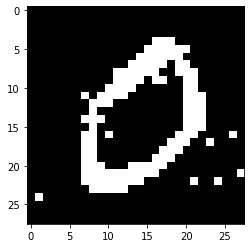

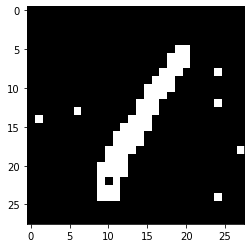

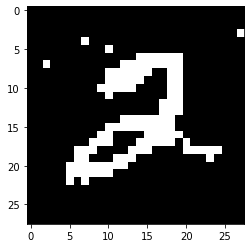

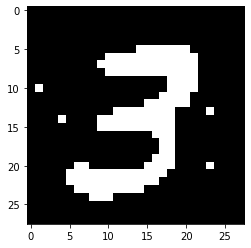

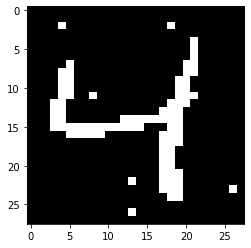

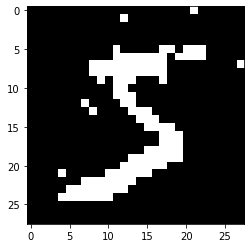

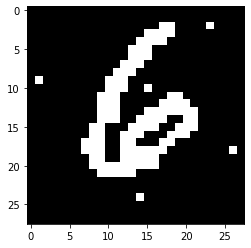

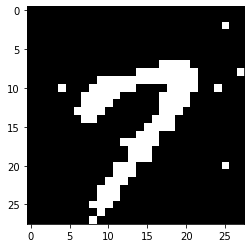

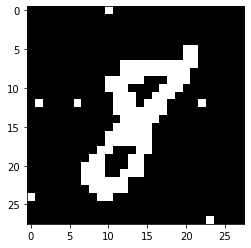

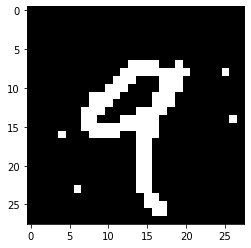

In [10]:
Y_1=Wrong_patterns(0.99,M)

Y_2=np.zeros(Y_1.shape)
Y_2[:,:]=Y_1[:,:]

Plot(crop_x,crop_y,Y_1,K)

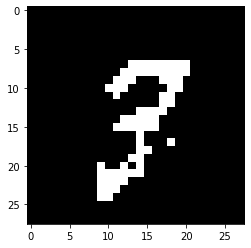

no pattern detected in: 4 iterations 



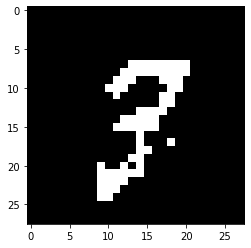

no pattern detected in: 3 iterations 



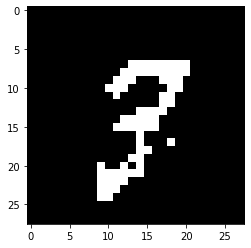

no pattern detected in: 4 iterations 



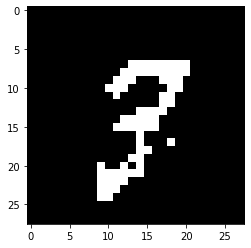

no pattern detected in: 4 iterations 



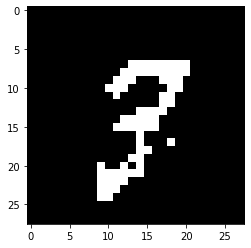

no pattern detected in: 4 iterations 



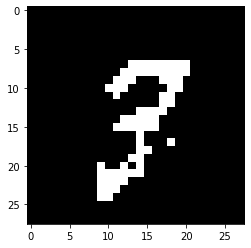

no pattern detected in: 4 iterations 



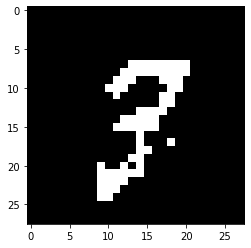

no pattern detected in: 4 iterations 



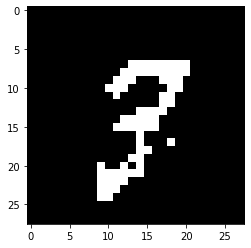

no pattern detected in: 3 iterations 



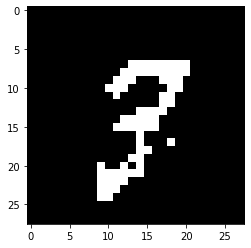

no pattern detected in: 4 iterations 



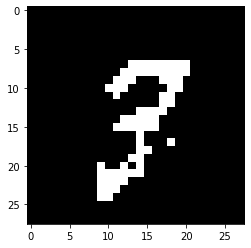

no pattern detected in: 3 iterations 



In [11]:
#Ricostruisce pattern senza interazion nn

for j in range(0,len(K)):
    pattern_giusto, iterazione= Update_y(J_matrix,Y_1[j],M, conf =5)
    
    M_inv = np.zeros((28-2*crop_x,28-2*crop_y,len(K)))
    M_inv[:,:,j] = Y_1[j].reshape(28-2*crop_x,28-2*crop_y)
    plt.imshow(M_inv[:,:,j], cmap=plt.get_cmap('gray'))
    plt.show()
    
    if pattern_giusto==-1:
        print('no pattern detected in:', iterazione, 'iterations \n')
    else:
        print('pattern detected: ', pattern_giusto, 'in ', iterazione, 'iterations \n')

In [12]:
#Ricostruisce pattern con interazion nn

# for j in range(0,len(K)):
#     pattern_giusto, iterazione= Update_y(J_corretta,Y_2[j],M, conf =5)
    
#     M_inv = np.zeros((28-2*crop_x,28-2*crop_y,len(K)))
#     M_inv[:,:,j] = Y_2[j].reshape(28-2*crop_x,28-2*crop_y)
#     plt.imshow(M_inv[:,:,j], cmap=plt.get_cmap('gray'))
#     plt.show()
    
#     if pattern_giusto==-1:
#         print('no pattern detected in:', iterazione, 'iterations \n')
#     else:
#         print('pattern detected: ', pattern_giusto, 'in ', iterazione, 'iterations \n')

CROP VARIA NO NN

In [13]:
K=[0,1,2,3,4,5,6,7,8,9]
database_detected_patterns=[]

for x in range(0,10):

    crop_x=x
    crop_y=x

    M=Input_mnist(crop_x,crop_y,K)
    M = np.array(M,dtype=np.float64)
    J_matrix=J(M)
    q_list=[0.9]

    database_detected_patterns.append(Detected_patterns_func(M,K,J_matrix,5,q_list))

[[0], [0], [0], [0], [0], [0], [0], [2], [3], [6]]


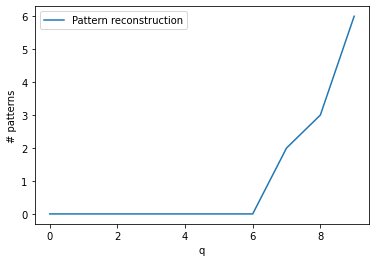

In [14]:
print(database_detected_patterns)
x=np.arange(0,10)

plt.plot(x,database_detected_patterns,label='Pattern reconstruction')
plt.ylabel('# patterns')
plt.xlabel('q')
plt.legend()
plt.show()

Arrivati qua, vediamo che in un immagine 12x12 comincia a riconoscere i pattern, però non riusciamo più a visualizzare bene i numeri. Se diminuiamo il numero dei K, la griglia di soglia sopra la quale si cominciano a riconosce i pattern diventa più grande. Facciamo vedere che un crop 12x12 non si vedono più bene i numeri:

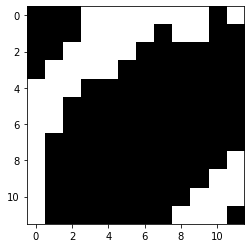

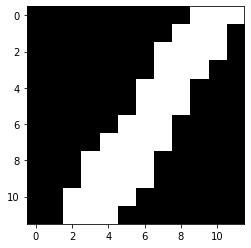

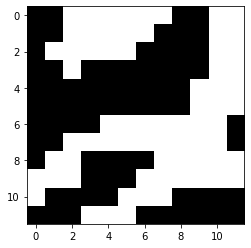

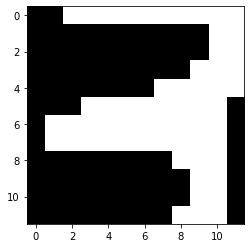

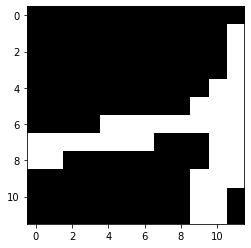

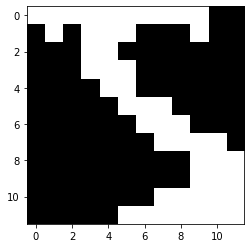

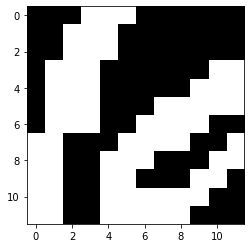

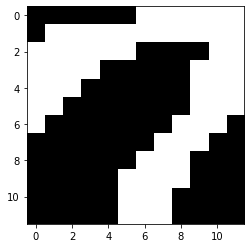

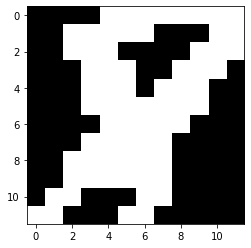

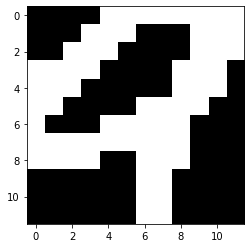

In [15]:
K=[0,1,2,3,4,5,6,7,8,9]
crop_x=8
crop_y=8

M=Input_mnist(crop_x,crop_y,K)
M = np.array(M,dtype=np.float64)

J_matrix=J(M)

Plot(crop_x,crop_y,M,K)

Si vedono male. Decidiamo di cropparci allora ad un 18x18 così da avere più informazioni sul 4, ma potrebbe andare anche bene un 16x16:

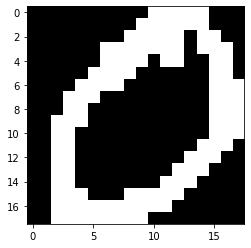

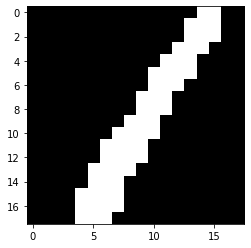

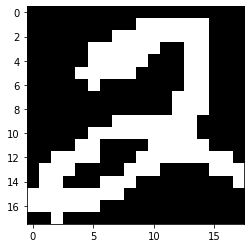

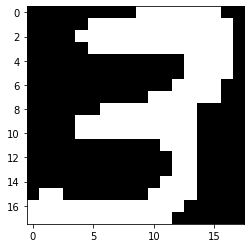

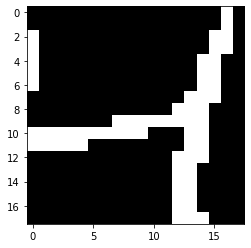

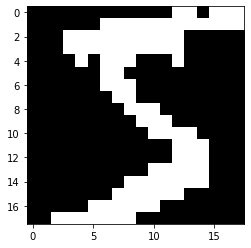

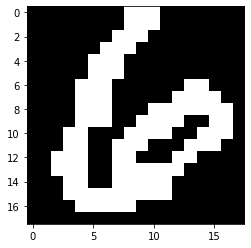

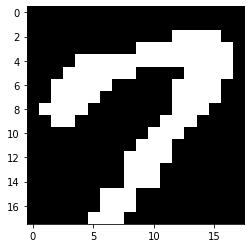

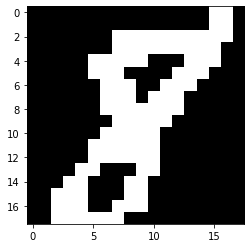

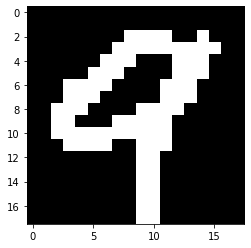

In [16]:
K=[0,1,2,3,4,5,6,7,8,9]
crop_x=5
crop_y=5

M=Input_mnist(crop_x,crop_y,K)
M = np.array(M,dtype=np.float64)

J_matrix=J(M)

Plot(crop_x,crop_y,M,K)

CROP 18 VARIAMO K SENZA INTERAZIONE VICINA

In [22]:
Database=[]

for k in range(0,10):
    K=[0,1]
    database_detected_patterns=[]
    
    for x in range(2,10):

        crop_x=5
        crop_y=5

        M=Input_mnist(crop_x,crop_y,K)
        M = np.array(M,dtype=np.float64)
        J_matrix=J(M)
        q_list=[0.6]

        database_detected_patterns.append(Detected_patterns_func(M,K,J_matrix,5,q_list))
        K.append(x)
        #print(K)
    Database.append(database_detected_patterns)

[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2]
[0, 1,

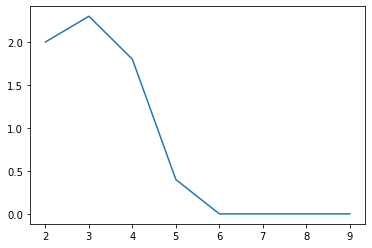

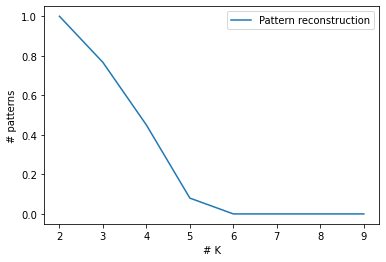

In [35]:
mean_arr=np.mean(Database, axis=0)
res=mean_arr.reshape(1,8)
#print(mean_arr.reshape(1,8))
x=np.arange(2,10)
y=np.zeros(res.shape)
y[:]=res[:]/x[:]
plt.plot(x,mean_arr)  #pattern riconosciuti
plt.show()
plt.plot(x,y.T,label='Pattern reconstruction')  #percentuale pattern riconosciuti
plt.ylabel('# patterns')
plt.xlabel('# K')
plt.legend()

A questa probabilità 0.6 notiamo che fino a 4 patterns questo metodo va bene. oltre non riusciamo più a riconoscerli.
Per queste percentuali e per riconoscere tutti questi pattern abbiamo bisogno di un altro metodo. Usiamo la J con interazione vicina

CROP + INTERAZIONE VICINA
Adesso consideriamo crop e interazione vicina, che è la migliore soluzione di tutte, calcolando i pattern riconosciuti al variare di q

In [36]:
K=[0,1,2,3,4,5,6,7,8,9]
crop_x=5
crop_y=5

M=Input_mnist(crop_x,crop_y,K)
M = np.array(M,dtype=np.float64)

J_matrix=J(M)

A=np.zeros((J_matrix.shape[0],J_matrix.shape[1]))
A[:,:]=J_matrix[:,:]
J_corretta=Interazione(A,(28-2*crop_y),2)

Qui gli diamo 10 giri e calcoliamo la media dei pattern riconosciuti al variare di q dopo 10 giri. Si noti che stiamo utilizzando tutti i numeri.

In [38]:
#interazione vicina MIGLIOR METODO DI TUTTI VIENE TUTTO BELLISSIMO
q_list=np.arange(0.1,1,0.005)

database_detected_patterns=[]
for k in range(0,10):
    database_detected_patterns.append(Detected_patterns_func(M,K,J_corretta,5,q_list))

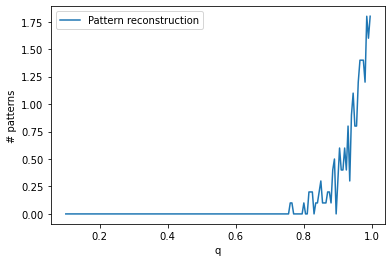

In [39]:
mean_arr=np.mean(database_detected_patterns, axis=0)

plt.plot(q_list,mean_arr,label='Pattern reconstruction')
plt.ylabel('# patterns')
plt.xlabel('q')
plt.legend()
plt.show()

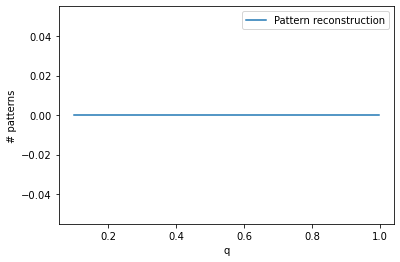

In [40]:
q_list=np.arange(0.1,1,0.005)

database_detected_patterns=[]
for k in range(0,10):
    database_detected_patterns.append(Detected_patterns_func(M,K,J_matrix,5,q_list))

mean_arr=np.mean(database_detected_patterns, axis=0)

plt.plot(q_list,mean_arr,label='Pattern reconstruction')
plt.ylabel('# patterns')
plt.xlabel('q')
plt.legend()
plt.show()